# INSY 6800 - EDA Project 

Project by Richie Wilbanks and Carly Walker

Project Description: Display EDA skills learned in INSY 6800 course by using a real world data set. The data set explored displays statistics for D1 NCAA Men's College Basketball teams ranging from 2010 to 2025. 

## Initial Data Setup 

In this section the data is imported from github, cleaned, and formatted into a dataframe so that the team can use the data for exploration. 

In [1]:
!pip install openpyxl
#Install to reach excel files 

In [2]:
#import pandas to handle DataFrames and Path for importing dataset
import pandas as pd
from pathlib import Path

#join current working directory to dataset
Project_Root = Path(".")
Data_Dir = Project_Root / "sports_data"

#import and sort excel files from dataset
excel_files = sorted(Data_Dir.glob("*.xls*"))

In [3]:
#Use function to load excel data for all seasons
def clean_season(path, season_name):

    # returns filename extension (.xls or .xlsx)
    ext = path.suffix.lower()

    # Run loop so function can support different file topes 
    if ext == ".xls":
        tables = pd.read_html(path, header=[0, 1])
        raw = tables[0]
    elif ext == ".xlsx":
        raw = pd.read_excel(path, header=[0, 1], engine="openpyxl")
    else:
        raise ValueError(f"Unsupported file type: {ext}")

    #Flatten column names 
    new_cols = []
    for col in raw.columns:
        # col is a tuple (ex: ("Overall", "W")
        if isinstance(col, tuple):
            top = str(col[0])
            sub = str(col[1])
        else:
            top = ""
            sub = str(col)

        # Cleaning data 
            #if school has no name
        if top.startswith("Unnamed") and sub == "School":
            name = "School"
        elif top == "Overall":
            # Tuples start with "Overall" but we want the sub header (ex: W, L, G)
            name = sub
        elif top == "Totals":
            # Tupes start with "Total" but we want sub header (ex: FG, 3P)
            name = sub
        elif top == "Points" and sub == "Tm.":
            #Make more readable 
            name = "PTS"
        elif top == "Points" and sub == "Opp.":
            #Make more readable 
            name = "Opp PTS"
        else:
            # For Conf., Home, Away, etc., create a unique name
            # that won't match keep_cols (so we ignore them)
            name = f"{top}_{sub}".strip()

        new_cols.append(name)

    raw.columns = new_cols

    #drop any completely empty columns
    raw = raw.dropna(axis=1, how="all")

    #Keep only wanted stats 
    keep_cols = [
        "School",
        "G", "W", "L", "W-L%", "SRS", "SOS",
        "PTS", "Opp PTS",
        "FG", "FGA", "FG%",
        "3P", "3PA", "3P%",
        "FT", "FTA", "FT%",
        "TRB", "AST", "STL", "BLK", "TOV"
    ]

    existing_cols = [col for col in keep_cols if col in raw.columns]
    missing_cols = [col for col in keep_cols if col not in raw.columns]

    #warning if column is missing 
    if missing_cols:
        print(f"For {season_name}, missing columns (skipped): {missing_cols}")

    df = raw[existing_cols].copy()

    #Remove duplicates 
    df = df.loc[:, ~df.columns.duplicated()]

    # Clean school names 
    if "School" in df.columns:
        df["School"] = (
            df["School"]
            .astype(str)
            .str.replace(r"\s*NCAA$", "", regex=True)
            .str.replace(r"\s*\(.*?\)", "", regex=True)
            .str.strip()
        )

    # Convert all numeric columns 
    for col in df.columns:
        if col != "School":
            #Ensures we are working with a series and not a data frame
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # Add a season column
    df["Season"] = season_name

    return df

In [4]:
#Creates a dictionary with the season name (ex: 2010-2011) as key name and values as the dataframe from above 
season_dfs = {}

#Loop through excel files and strip so season name is the years 
for file in excel_files:
    name = file.stem
    season_name = name.split("_")[-1]  # ex: 2024-2025

    df_season = clean_season(file, season_name) # use fuction from above 
    season_dfs[season_name] = df_season

    #confirm the season was loaded 
    print("Loaded season:", season_name, "Shape:", df_season.shape)


Loaded season: 2010-2011 Shape: (345, 24)
Loaded season: 2011-2012 Shape: (344, 24)
Loaded season: 2012-2013 Shape: (347, 24)
Loaded season: 2013-2014 Shape: (351, 24)
Loaded season: 2014-2015 Shape: (351, 24)
Loaded season: 2015-2016 Shape: (351, 24)
Loaded season: 2016-2017 Shape: (351, 24)
Loaded season: 2017-2018 Shape: (351, 24)
Loaded season: 2018-2019 Shape: (353, 24)
Loaded season: 2019-2020 Shape: (353, 24)
Loaded season: 2020-2021 Shape: (347, 24)
Loaded season: 2021-2022 Shape: (358, 24)
Loaded season: 2022-2023 Shape: (363, 24)
Loaded season: 2023-2024 Shape: (363, 24)
Loaded season: 2024-2025 Shape: (364, 24)


In [5]:
#concatenate all cleaned seasons - create one data frame with all seasons data 
df_all = pd.concat(season_dfs.values(), ignore_index=True)
# remove rows with missing values
df_all = df_all.dropna().reset_index(drop=True)

## Question 1: Which team statistics have the strongest relationship with winning percentage? 

This question hopes to expose which factors have the strongest correlation with winning. For example, are teams with higher blocking stats winning more games?

In [28]:
#remove the columns that are win/lose percentages
exclude = ["W", "L", "W-L%"]

# Keep only stat columns (only numerical columns)
numeric_cols = [
    col for col in df_all.select_dtypes(include="number").columns
    if col not in exclude
]

correlation_data = df_all[numeric_cols].corrwith(df_all["W-L%"]).sort_values()

C:\Users\carly\AppData\Local\Temp\ipykernel_26376\3218933119.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_data.values, y=correlation_data.index, palette="coolwarm")


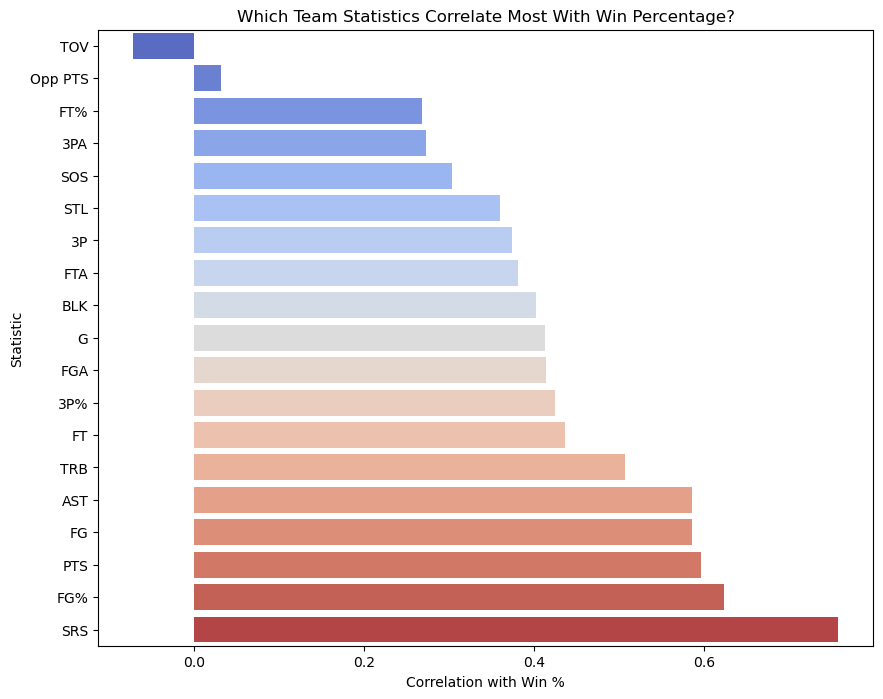

In [34]:
plt.figure(figsize=(10,8))
sns.barplot(x=correlation_data.values, y=correlation_data.index, palette="coolwarm")
plt.title("Which Team Statistics Correlate Most With Win Percentage?")
plt.xlabel("Correlation with Win %")
plt.ylabel("Statistic")
plt.show()

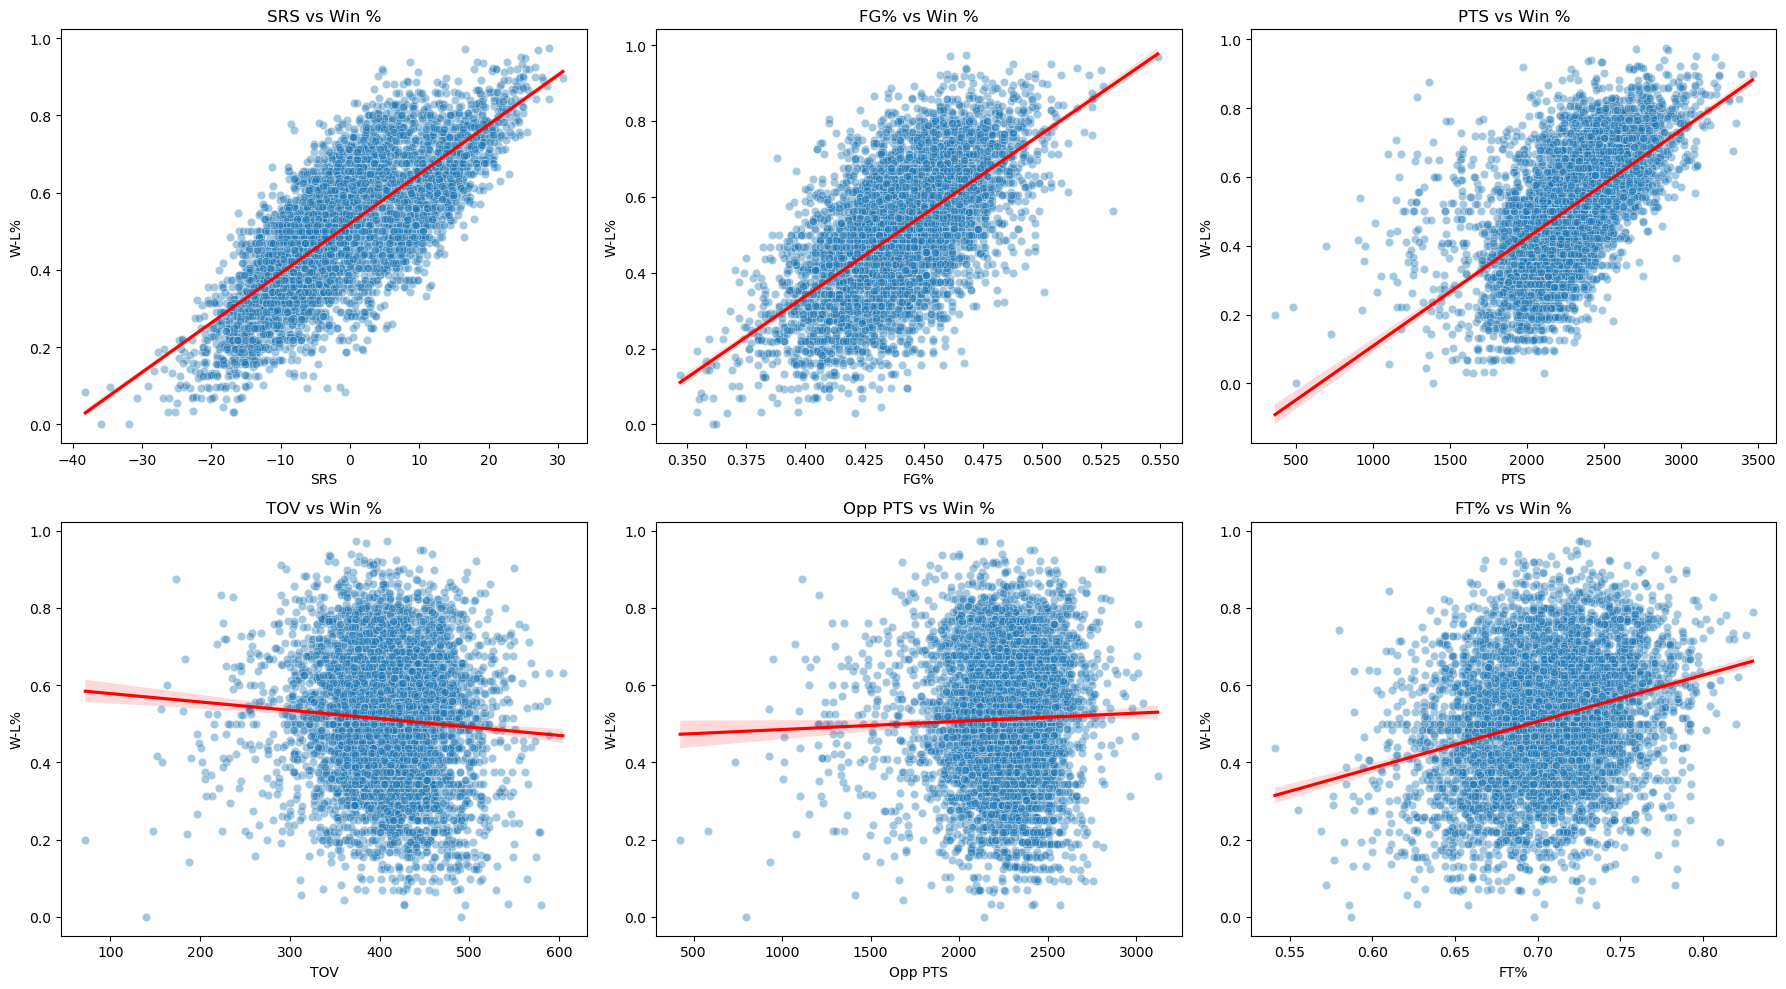

In [36]:
key_stats = ["SRS", "FG%", "PTS", "TOV", "Opp PTS", "FT%"]  # bottom 3 and top three stats

plt.figure(figsize=(18,10))

for i, stat in enumerate(key_stats, 1):
    plt.subplot(2, 3, i)  
    sns.scatterplot(data=df_all, x=stat, y="W-L%", alpha=0.4)
    sns.regplot(data=df_all, x=stat, y="W-L%", scatter=False, color="red")
    plt.title(f"{stat} vs Win %")

plt.tight_layout()
plt.show()

### Takeways: 

To find answers to the given question, "Which statistics best explain why certain teams win more games?", I first computed the correlations between each team stat and the teams win percentage. The first iteration of my graph included W, L, and W-L% but these factors directly showed wins and loses so I removed these from the analysis. This left the remaining numerical statistics which revealed certain factors as positive and negative associations with winning. For example, turnovers correlated negatively with win percentage and SRS (simple rating system), FG%, and total points scored all correlated positively. This shows that both offense and defense performance play a large role in helping a team succeed. 


Next, I graphed six of the key metrics: the 3 metrics on the bottom and top of the correlation list to show how the strongest psotive and negative correlations appear across all teams and seasons. The six scatterplots above show that a higher SRS, FG% and points scored all align with stronger win percentages and turnovers and opponents points trend downwards. This can help coaches and players to become aligned on there teams vision and find specific areas to focus on when preparing and playing. 

## Question 2: Are stats shifting over time? (carly section)

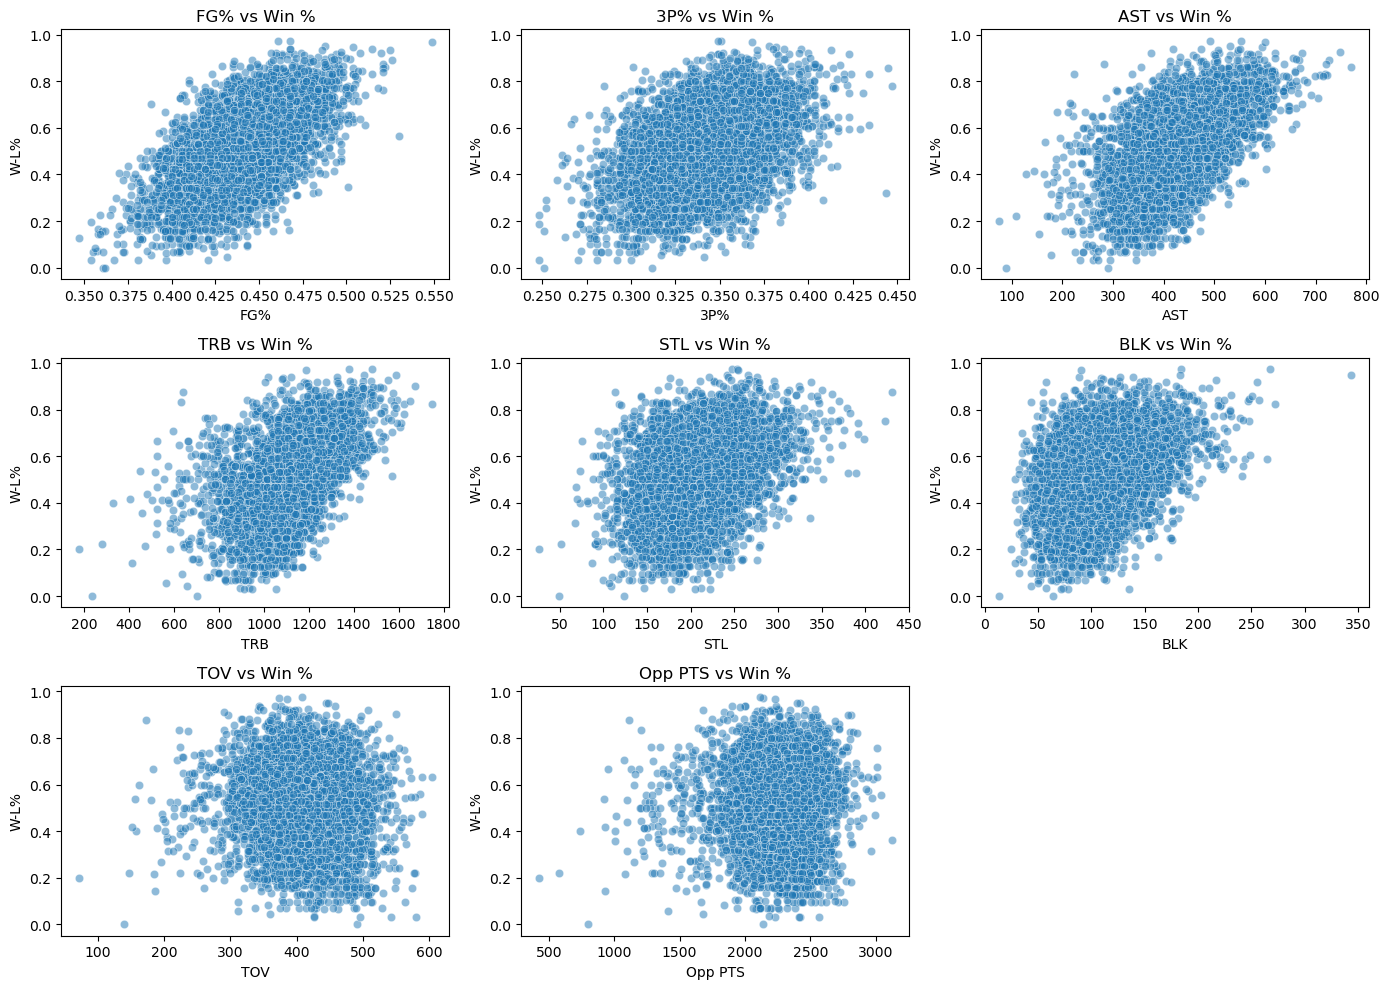

In [8]:
key_stats = ["FG%", "3P%", "AST", "TRB", "STL", "BLK", "TOV", "Opp PTS"]

plt.figure(figsize=(14,10))
for i, col in enumerate(key_stats):
    plt.subplot(3,3,i+1)
    sns.scatterplot(data=df_all, x=col, y="W-L%", alpha=0.5)
    plt.title(f"{col} vs Win %")
plt.tight_layout()
plt.show()

NameError: name 'yearly' is not defined

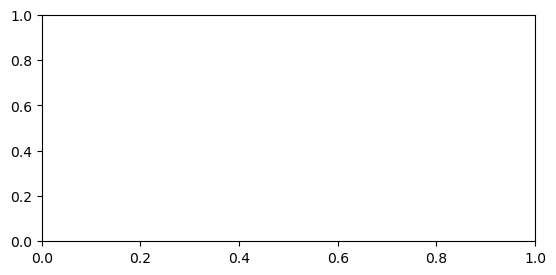

In [9]:
stats_to_plot = ["3PA", "3P%", "FG%", "Opp PTS", "TOV"]

plt.figure(figsize=(14,10))
for i, col in enumerate(stats_to_plot):
    plt.subplot(3,2,i+1)
    sns.lineplot(data=yearly, x=yearly.index, y=col)
    plt.xticks(rotation=90)
    plt.title(f"{col} Over Time")
plt.tight_layout()
plt.show()

## Question 3: Do certain teams have statisical "signatures"? (carly Section)

In [10]:
from scipy.stats import zscore

team_stats = df_all.groupby("School")[numeric_cols].mean()
team_z = team_stats.apply(zscore)

In [11]:
team_z.loc[["Auburn", "Duke", "Virginia", "Gonzaga"]]

,G,W,L,W-L%,SRS,SOS,PTS,Opp PTS,FG,FGA,...,3PA,3P%,FT,FTA,FT%,TRB,AST,STL,BLK,TOV
School,,,,,,,,,,,,,,,,,,,,,
Auburn,0.783094,0.784721,-0.699037,0.711540,1.314730,1.512250,1.073131,0.883611,0.618927,1.160116,...,1.449710,-0.595257,1.756739,1.947857,-0.370619,0.940417,0.525419,1.243739,2.524552,0.326349
Duke,2.753661,2.859751,-2.589606,2.504614,2.477372,1.803943,3.302768,1.472103,3.244132,2.804629,...,1.698388,1.952453,2.419451,2.084927,1.199067,2.541298,2.476350,1.732169,2.427636,-0.315907
Virginia,1.086258,1.903292,-2.037305,1.940974,1.784953,1.519477,-0.556280,-3.087899,-0.179382,-0.720648,...,-0.964258,1.651316,-1.456647,-1.687324,0.866823,-0.305686,0.771286,-0.481296,1.143504,-2.880205
Gonzaga,2.551552,3.313664,-3.269361,3.097698,2.384178,0.972351,3.749010,0.920106,4.118104,2.521525,...,0.414342,2.392207,2.399416,2.149497,1.015994,2.846645,3.315788,1.531715,1.164704,-0.280488


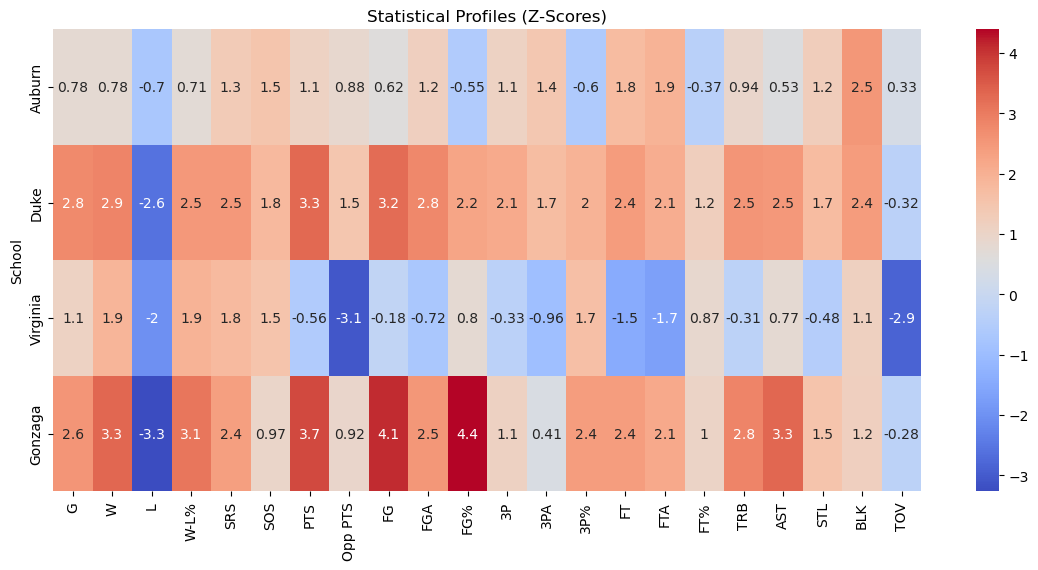

In [12]:
plt.figure(figsize=(14,6))
sns.heatmap(team_z.loc[["Auburn", "Duke", "Virginia", "Gonzaga"]], annot=True, cmap="coolwarm")
plt.title("Statistical Profiles (Z-Scores)")
plt.show()

## Question 4: Outliers or breakout seasons? (carly)

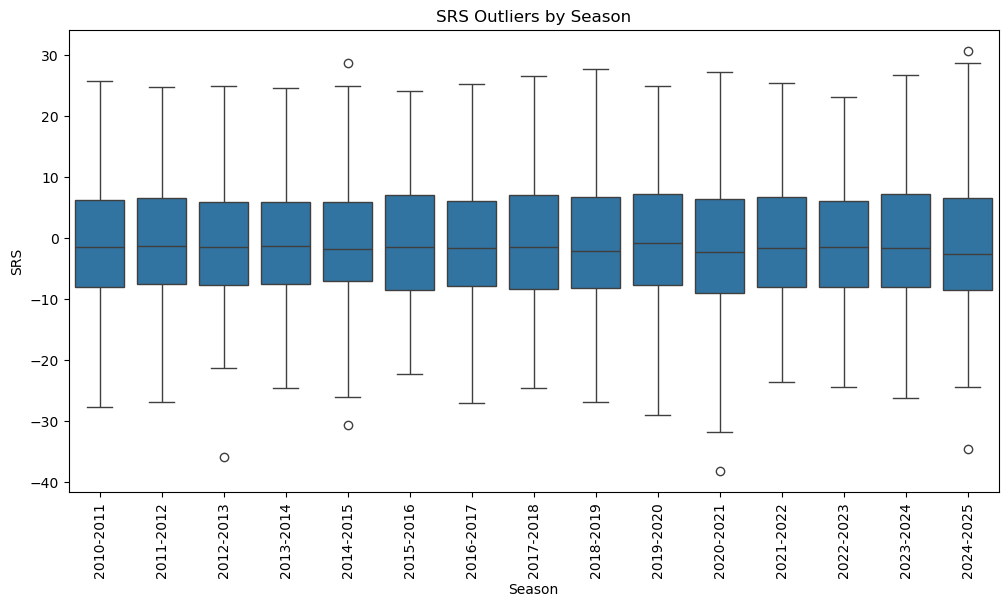

In [13]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_all, x="Season", y="SRS")
plt.xticks(rotation=90)
plt.title("SRS Outliers by Season")
plt.show()

In [14]:
df_all.nlargest(10, "SRS")[["School", "Season", "SRS", "W-L%"]]

,School,Season,SRS,W-L%
5000,Duke,2024-2025,30.72,0.897
1522,Kentucky,2014-2015,28.72,0.974
4943,Auburn,2024-2025,28.68,0.842
5040,Houston,2024-2025,28.45,0.875
2892,Gonzaga,2018-2019,27.79,0.892
5013,Florida,2024-2025,27.78,0.900
3594,Gonzaga,2020-2021,27.20,0.969
2863,Duke,2018-2019,26.90,0.842
4624,Connecticut,2023-2024,26.70,0.925
2766,Villanova,2017-2018,26.64,0.900


In [15]:
team_year = df_all.pivot_table(values="W-L%", index="Season", columns="School")

improvement = team_year.diff().max()
improvement.nlargest(10)


School
McNeese State           0.558
Towson                  0.550
Bryant                  0.546
Iowa State              0.546
Southern Mississippi    0.546
Louisville              0.521
UC Santa Barbara        0.505
UC Davis                0.491
Middle Tennessee        0.486
Tennessee State         0.484
dtype: float64

## Question 5: Richie

## Question 6: Richie

## Question 7: Richie

## Question 8: Richie 

## Takeaways/Conclusion: Richie 